# Noncovalent interactions and NMR observables
## Some ideas for the NONCOV Toolbox in Python

### Ettore Bartalucci, Progress Report 17.09.2024

## Preconfig NONCOVToolbox Library

In [1]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [2]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

test_dir = os.path.abspath(os.path.join('..', 'tests'))
print(f'Current test directory is: {test_dir}')
test_dir = OrcaAnalysis().convert_path(test_dir)

mol_dir = os.path.join(scratch_dir, 'StructureModifier/input_structures/benzene_H2O.xyz')
print(f'Current molecule directory is: {mol_dir}')
mol_dir = OrcaAnalysis().convert_path(mol_dir)

Current work directory is: C:\Users\ettor\Desktop\NONCOV\geom_dep
Current scratch directory is: C:\Users\ettor\Desktop\NONCOV\scratch
Normalized path using os.path: C:/Users/ettor/Desktop/NONCOV/scratch
Current test directory is: C:\Users\ettor\Desktop\NONCOV\tests
Normalized path using os.path: C:/Users/ettor/Desktop/NONCOV/tests
Current molecule directory is: C:/Users/ettor/Desktop/NONCOV/scratch\StructureModifier/input_structures/benzene_H2O.xyz
Normalized path using os.path: C:/Users/ettor/Desktop/NONCOV/scratch/StructureModifier/input_structures/benzene_H2O.xyz


## Preallocate two empty dataframes for ML applications with @GenerateMLDataset

We first have to make the dataframes where we will store all the relevant data and these will then be used for plotting trends, Machine Learning ecc..

In [3]:
# RUN THIS CELL ONLY IF YOU NEVER CREATED THE EMPTY DATASET BEFORE
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

if os.listdir(datasets_dir) == []:
    print("No files found in the directory, creating datasets... \n")
    # Make the dataset for the pairwise NMR properties
    MachineLearning().make_empty_pairwise_prop_df(datasets_dir)
    
    # Make the dataset for the individual NMR properties
    MachineLearning().make_empty_nuc_prop_df(datasets_dir)
else:
    print("Some files found in the directory, skipping... \n")

Dataset directory is: C:/Users/ettor/Desktop/NONCOV/scratch\GenerateMLDataset/data/
Normalized path using os.path: C:/Users/ettor/Desktop/NONCOV/scratch/GenerateMLDataset/data/
No files found in the directory, creating datasets... 

The empty pairwise nuclear property dataset has been created and saved in: C:/Users/ettor/Desktop/NONCOV/scratch/GenerateMLDataset/data/pairwise_nuc_prop_nmr_observables.csv


The empty nuclear property dataset has been created and saved in: C:/Users/ettor/Desktop/NONCOV/scratch/GenerateMLDataset/data/nuc_prop_nmr_observables.csv




In [4]:
# Display how the empty databases look like
nucprop = os.path.join(datasets_dir, 'nuc_prop_nmr_observables.csv')
nucprop_df = pd.read_csv(nucprop)

pw_nucprop = os.path.join(datasets_dir, 'pairwise_nuc_prop_nmr_observables.csv')
pw_nucprop_df = pd.read_csv(pw_nucprop)

In [5]:
# Individual nuclear properties
nucprop_df

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,s_tot_symmetry


In [6]:
# Pairwise nuclear properties
pw_nucprop_df

,Molecule,Atom_1,Atom_2,r_12,x_coord_1,y_coord_1,z_coord_1,x_coord_2,y_coord_2,z_coord_2,...,J_DSO_xx,J_DSO_yy,J_DSO_zz,J_PSO_xx,J_PSO_yy,J_PSO_zz,J_SD_xx,J_SD_yy,J_SD_zz,Mayer_BO


## Postprocess NMR tensors with @NMRFunctions

$\textbf{All of the above transformations (and others e.g. Euler angles extractions) are done in the background by the @NMRFunctions module}$

Perform all the necessary calculations to e.g. transform a shielding tensor from the molecular frame to the PAS and order eigenvalues following either Mehring or Haberlen conventions based on user choices.

In [ ]:
random_tensor = [[0, -2, 2],
                 [1, 3, 1],
                 [-1, 2, 0]]

shielding_tensor, s_iso, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions().diagonalize_tensor(random_tensor)

## Postprocessing with @OrcaAnalysis

Extract all parameters of interest from the very large ORCA output file and store them in the database for Machine Learning applications.

In [7]:
# Provide files you want to process as input 
#"C:\Users\ettor\Desktop\NONCOV\tests\data\run_all_displaced_distances.mpi8.out"
orca_output = input("Enter the path to the ORCA file you want to work with: ")
orca_output = OrcaAnalysis().convert_path(orca_output)

Enter the path to the ORCA file you want to work with: "C:\Users\ettor\Desktop\NONCOV\tests\benzene_H2O\benzene_H2O_relaxH_multi.mpi8.out"
Normalized path using os.path: C:/Users/ettor/Desktop/NONCOV/tests/benzene_H2O/benzene_H2O_relaxH_multi.mpi8.out


In [8]:
# Get the head of the file for saving files later
basename = os.path.basename(orca_output)
outname = basename.split('.')[0]

In [9]:
# Get a list of all the molecule names in the calculation, needed for ML later
list_molecules = OrcaAnalysis().extract_molecule_names(orca_output)
print(f'You have calculated the following molecules: {list_molecules}\n')

You have calculated the following molecules: ['benzene_H2O_relaxH_disp_struct_0.xyz', 'benzene_H2O_relaxH_disp_struct_1.xyz', 'benzene_H2O_relaxH_disp_struct_10.xyz', 'benzene_H2O_relaxH_disp_struct_11.xyz', 'benzene_H2O_relaxH_disp_struct_12.xyz', 'benzene_H2O_relaxH_disp_struct_13.xyz', 'benzene_H2O_relaxH_disp_struct_14.xyz', 'benzene_H2O_relaxH_disp_struct_15.xyz', 'benzene_H2O_relaxH_disp_struct_16.xyz', 'benzene_H2O_relaxH_disp_struct_17.xyz', 'benzene_H2O_relaxH_disp_struct_18.xyz', 'benzene_H2O_relaxH_disp_struct_19.xyz', 'benzene_H2O_relaxH_disp_struct_2.xyz', 'benzene_H2O_relaxH_disp_struct_3.xyz', 'benzene_H2O_relaxH_disp_struct_4.xyz', 'benzene_H2O_relaxH_disp_struct_5.xyz', 'benzene_H2O_relaxH_disp_struct_6.xyz', 'benzene_H2O_relaxH_disp_struct_7.xyz', 'benzene_H2O_relaxH_disp_struct_8.xyz', 'benzene_H2O_relaxH_disp_struct_9.xyz']



In [10]:
# Working with ORCA .out files

# Count how many sequential calculations have been done
n_jobs = OrcaAnalysis().count_jobs_number(orca_output)
print(f'Number of ORCA jobs in file: {n_jobs}\n')

# Compute size of the .out file and suggest Git LFS 
size_orca_output = os.path.getsize(orca_output)
size_orca_output = size_orca_output/1e6
print(f'Size of ORCA file is: {size_orca_output} MB\n')

if n_jobs > 20:
    print(f'Careful, you are working with a possibly large output file of several GB\n')
    print(f'If using version controls consider setting up a .gitignore \n')

if size_orca_output > 1:
    print(f"Careful, you are working with a '{size_orca_output}' KB large file..\n")
    print(f'Set up a .gitignore or Git LFS before pushing to Git\n')

# Extract level of theory
lot_out = OrcaAnalysis().extract_level_of_theory(orca_output)
print(f'Level of theory for the NMR calculations is: {lot_out}\n')

# Split orca output in several subfiles for ease of handling (takes a while)
if n_jobs > 2:
    print('Your output file will be now spilt into subfiles. \n')
    OrcaAnalysis().split_orca_output(scratch_dir, orca_output)

Number of ORCA jobs in file: 20

Size of ORCA file is: 165.092537 MB

Careful, you are working with a '165.092537' KB large file..

Set up a .gitignore or Git LFS before pushing to Git

Level of theory for the NMR calculations is: Job started from odin1, running /scratch/bartalucci/benzene_H2O_relaxH_multi__qBdtgN__120537/orca/orca

Your output file will be now spilt into subfiles. 

Output file path is C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalysis/split_orca_output/splitted_orca_job1.out
Wrote job 1 to C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalysis/split_orca_output/splitted_orca_job1.out
Output file path is C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalysis/split_orca_output/splitted_orca_job2.out
Wrote job 2 to C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalysis/split_orca_output/splitted_orca_job2.out
Output file path is C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalysis/split_orca_output/splitted_orca_job3.out
Wrote job 3 to C:/Users/ettor/Desktop/NONCOV/scratch\OrcaAnalys

### Extract the CSA tensor components for each nucleus at each distance iteration


In [11]:
# Initialize variables for shielding tensor components
S_dia = []
S_para = []
S_tot = []
nuclear_identities = []
mayer_bo = []
nuc_coords = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1): # split files = number of jobs
        
    blockPrint()
    
    # Path to the splitted outputs from the .out MPI8 file
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output', f'splitted_orca_job{job_number}.out'))

    # Extract CSA data
    shielding_dia, shielding_para, shielding_tot, nucleus_info = OrcaAnalysis().extract_tensor_data(orca_splitted_output)

    # Here include j coupling extraction
    #-------------
    
    # Extract bond orders
    bond_orders = OrcaAnalysis().extract_mayer_bond_order(orca_splitted_output)
    
    # Print the bond orders and their interacting nuclei
    for nucleus, bonds in bond_orders.items():
        print(f"{nucleus}:")
        for interacting_nucleus, bond_order in bonds:
            print(f"  Bond with {interacting_nucleus}: {bond_order}")
    
    enablePrint()
    
    coords = OrcaAnalysis().extract_xyz_coords(orca_splitted_output)
    
    # Append shielding tensor matrices (non-diagonalized) - all nuclei for each job iteration
    S_dia.append(shielding_dia)
    S_para.append(shielding_para)
    S_tot.append(shielding_tot)
    nuclear_identities.append(nucleus_info)
    
    # Append bond orders
    mayer_bo.append(bond_orders)
    
    # Append coordinates
    nuc_coords.append(coords)

### Application example 1) Chemical Shielding Tensor

In [15]:
# Get all the data that are not pairwise
data = []

# Loop through the number of jobs and get each molecule, each job has a different one
for job_number in range(n_jobs):
    molecule_name = list_molecules[job_number]
    
    # Process each job for S_tot
    shielding_dict = S_tot[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            shielding_tensor, s_iso, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            sigma_xx = eigenvals[0]
            sigma_yy = eigenvals[1]
            sigma_zz = eigenvals[2]
            
            sigma_11 = diagonal_mehring[0][0]
            sigma_22 = diagonal_mehring[1][1]
            sigma_33 = diagonal_mehring[2][2]
            
            # Extract coordinates and identities for the current nucleus
            nuc_id = nuclear_identities[job_number][nucleus_index]
            
            # Handle different structures of nuc_coords
            coords = nuc_coords[job_number][nucleus_index]
            if len(coords) >= 3:
                x_coord = coords[1]
                y_coord = coords[2]
                z_coord = coords[3]
            else:
                x_coord = y_coord = z_coord = None  

            # Collect the data for this nucleus
            row_data = {
                'Molecule': molecule_name,
                'Atom': nuc_id,
                'x_coord': x_coord,
                'y_coord': y_coord,
                'z_coord': z_coord,
                'sigma_iso': s_iso,
                'sigma_xx': sigma_xx,
                'sigma_yy': sigma_yy,
                'sigma_zz': sigma_zz,
                'dia_sigma_xx': None,  
                'dia_sigma_yy': None,
                'dia_sigma_zz': None,
                'para_sigma_xx': None,  
                'para_sigma_yy': None,
                'para_sigma_zz': None,
                'sigma_11' : sigma_11,
                'sigma_22' : sigma_22,
                'sigma_33' : sigma_33,
                's_tot_symmetry' : symmetry
            }
            data.append(row_data)

    # After collecting data from S_tot, update with data from S_dia
    shielding_dict = S_dia[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            dia_shielding_tensor, dia_s_iso, dia_diagonal_mehring, dia_diagonal_haberlen, dia_eigenvals, dia_eigenvecs, dia_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            dia_sigma_xx = dia_eigenvals[0]
            dia_sigma_yy = dia_eigenvals[1]
            dia_sigma_zz = dia_eigenvals[2]

            # Update the existing row_data with dia_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'dia_sigma_xx': dia_sigma_xx,
                        'dia_sigma_yy': dia_sigma_yy,
                        'dia_sigma_zz': dia_sigma_zz
                    })

    # After collecting data from S_dia, update with data from S_para
    shielding_dict = S_para[job_number]
    if isinstance(shielding_dict, dict):
        for nucleus_index, (nucleus_key, tensor) in enumerate(shielding_dict.items()):
            para_shielding_tensor, para_s_iso, para_diagonal_mehring, para_diagonal_haberlen, para_eigenvals, para_eigenvecs, para_symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            para_sigma_xx = para_eigenvals[0]
            para_sigma_yy = para_eigenvals[1]
            para_sigma_zz = para_eigenvals[2]

            # Update the existing row_data with para_sigma values
            for row in data:
                if row['Molecule'] == molecule_name and row['Atom'] == nucleus_key:
                    row.update({
                        'para_sigma_xx': para_sigma_xx,
                        'para_sigma_yy': para_sigma_yy,
                        'para_sigma_zz': para_sigma_zz
                    })

# Convert the list of rows to a DataFrame
datadf = pd.DataFrame(data)

# Concatenate with the existing DataFrame
nucprop_df = pd.concat([nucprop_df, datadf], ignore_index=True)

# Save the updated DataFrame to a CSV file
nucprop_df.to_csv(nucprop, index=False)

# Display the updated DataFrame
nucprop_df


,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,s_tot_symmetry
0,benzene_H2O_relaxH_disp_struct_0.xyz,Nucleus 0H :,1.262496,-0.430661,2.134433,23.67,27.05,23.10,20.85,43.22,28.25,21.04,-20.23,-1.20,-0.08,20.85,23.10,27.05,0
1,benzene_H2O_relaxH_disp_struct_0.xyz,Nucleus 3H :,0.725262,-0.290962,1.201459,23.79,27.01,23.39,20.98,43.09,29.18,22.81,-19.89,-2.33,-1.49,20.98,23.39,27.01,0
2,benzene_H2O_relaxH_disp_struct_0.xyz,Nucleus 5H :,-0.653711,-0.107857,1.2151,23.88,21.06,23.61,26.97,42.63,23.59,29.92,-19.27,-2.39,-2.85,21.06,23.61,26.97,0
3,benzene_H2O_relaxH_disp_struct_0.xyz,Nucleus 7H :,-1.192142,-0.111533,2.158714,23.62,27.01,22.98,20.88,43.39,28.25,21.75,-20.56,-1.31,-0.64,20.88,22.98,27.01,0
4,benzene_H2O_relaxH_disp_struct_0.xyz,Nucleus 9H :,-1.341293,0.087002,0.021568,23.64,27.06,23.03,20.83,42.79,28.70,21.04,-19.88,-1.64,-0.10,20.83,23.03,27.06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,benzene_H2O_relaxH_disp_struct_9.xyz,Nucleus 4C :,1.416524,-0.279186,-0.005713,47.56,-68.83,176.23,35.29,235.92,256.75,268.83,-59.71,-325.62,-233.49,-68.83,35.29,176.23,0
296,benzene_H2O_relaxH_disp_struct_9.xyz,Nucleus 6C :,2.493447,-0.41546,-0.016421,47.08,-69.21,33.83,176.63,267.17,257.88,235.51,-327.12,-233.32,-58.87,-69.21,33.83,176.63,0
297,benzene_H2O_relaxH_disp_struct_9.xyz,Nucleus 8C :,0.245755,4.59114,0.380695,46.77,-69.61,33.24,176.69,267.94,256.89,235.24,-326.52,-234.67,-58.56,-69.61,33.24,176.69,0
298,benzene_H2O_relaxH_disp_struct_9.xyz,Nucleus 10C :,0.545267,5.505176,0.43798,46.67,-69.92,176.56,33.38,235.16,256.57,268.29,-58.63,-326.47,-234.90,-69.92,33.38,176.56,0


<AxesSubplot:>

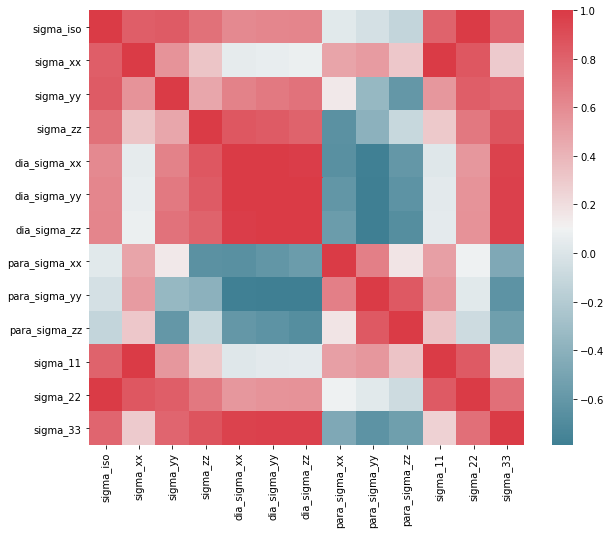

In [16]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import data
df = nucprop_df

# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Shielding changes with distance

In [ ]:
df = nucprop_df

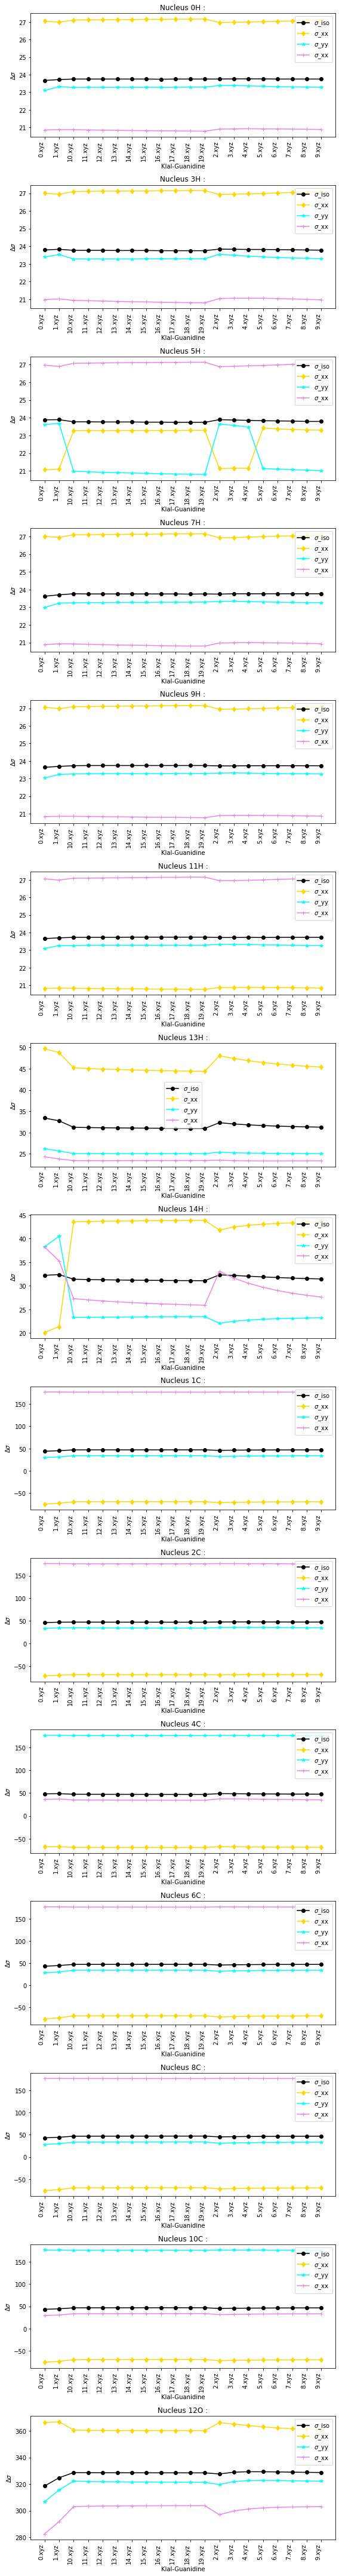

In [24]:
import re

unique_nuclei = df['Atom'].unique()

# Define number of subplots
num_nuclei = len(unique_nuclei)

# Create subplots
fig, axs = plt.subplots(num_nuclei, 1, figsize=(8, 4 * num_nuclei))

# If only one nucleus, axs is not a list, so convert it to list for consistency
if num_nuclei == 1:
    axs = [axs]
    
def remove_prefix(molecule_name, prefix="benzene_H2O_relaxH_disp_struct_"):
    return molecule_name.replace(prefix, '')
    
# Loop through each unique nucleus and create a plot
for i, nucleus in enumerate(unique_nuclei):
    # Filter data for the current nucleus
    nucleus_data = df[df['Atom'] == nucleus]
    
    molecule_suffixes = [remove_prefix(molecule) for molecule in nucleus_data['Molecule']]
    
    # Plot sigma_iso against molecule index or name
    axs[i].plot(molecule_suffixes, nucleus_data['sigma_iso'], marker='o', color='black', label='$\sigma$_iso')
    
    axs[i].plot(molecule_suffixes, nucleus_data['sigma_xx'], marker='d', color='gold', label='$\sigma$_xx')
    axs[i].plot(molecule_suffixes, nucleus_data['sigma_yy'], marker='*', color='cyan', label='$\sigma$_yy')
    axs[i].plot(molecule_suffixes, nucleus_data['sigma_zz'], marker='+', color='violet', label='$\sigma$_xx')

    # Set labels and title
    axs[i].set_title(f'{nucleus}')
    axs[i].set_xlabel('benzene_h2o')
    axs[i].set_ylabel('$\Delta$$\sigma$')
    
    axs[i].set_xticks(range(len(molecule_suffixes)))
    axs[i].set_xticklabels(molecule_suffixes, rotation=90, ha="right")
       
    axs[i].legend()

plt.tight_layout()

plt.show()

### Barplots of Shielding changes with distance for Guanidine

In [ ]:
# Here plot bar plots to show how much is the deviation

unique_nuclei = df['Atom'].unique()

# Define number of subplots
num_nuclei = len(unique_nuclei)

# Create subplots
fig, axs = plt.subplots(num_nuclei, 1, figsize=(8, 4 * num_nuclei))

# If only one nucleus, axs is not a list, so convert it to list for consistency
if num_nuclei == 1:
    axs = [axs]

# Loop through each unique nucleus and create a box plot
for i, nucleus in enumerate(unique_nuclei):

    nucleus_data = df[df['Atom'] == nucleus]
    
    # Create a box plot for sigma_iso, sigma_11, sigma_22, sigma_33
    data_to_plot = [nucleus_data['sigma_iso'], 
                    nucleus_data['sigma_11'], 
                    nucleus_data['sigma_22'], 
                    nucleus_data['sigma_33']]
    
    # Create the box plot
    axs[i].boxplot(data_to_plot, labels=['sigma_iso', 'sigma_11', 'sigma_22', 'sigma_33'])
    
    # Set title and labels
    axs[i].set_title(f'Box Plot for {nucleus}')
    axs[i].set_ylabel('Sigma values')
    
# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


# Unsupervised Learning 

Here we use algortithms to elucidate the structure of the training data. We cluster the data points in groups, and project them in two dimensions to understand their distribution.

<ipython-input-25-928b22181afc>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  caxes = pd.plotting.scatter_matrix(nucprop_df, ax=ax)


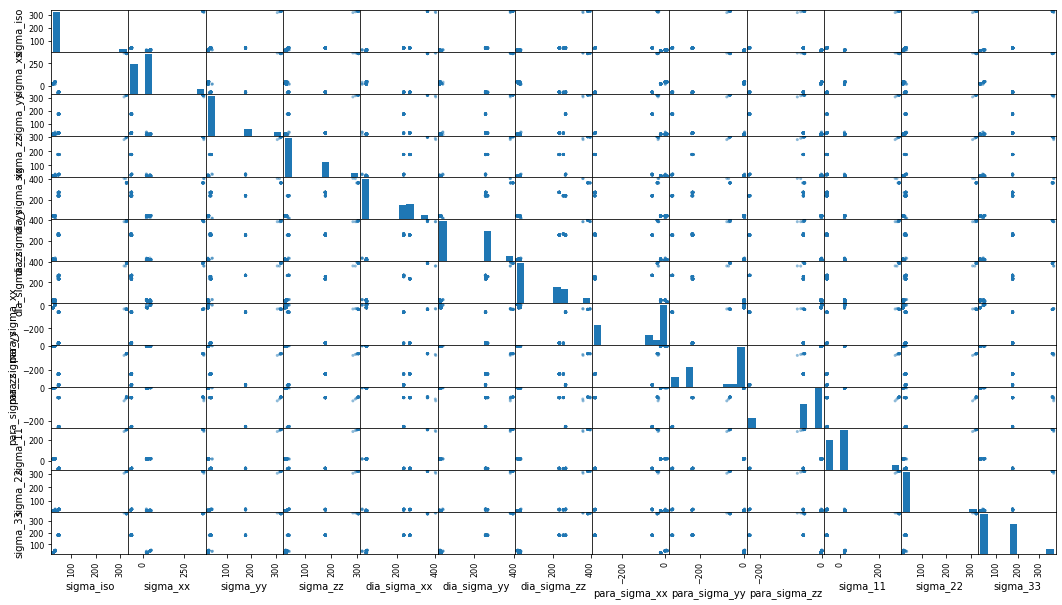

In [25]:
# The following figure shows us a table with scatter plots for each two pairs of features.
# The diagonal plots are the histograms for the variables

fig, ax = plt.subplots(figsize=[18,10])
caxes = pd.plotting.scatter_matrix(nucprop_df, ax=ax)
plt.show()

In [26]:
# clustering algorithm
from sklearn.cluster import KMeans

# linear dimensionality analysis
from sklearn.decomposition import PCA

# nonlinear dimensionality analysis
from sklearn.manifold import TSNE

In [27]:
# Unsupervised learning methods are sensistive to the mean value and the variance of each feature. 
# Here we normalize the data so all the features have zero mean and equal variance
real_nucprop_df = nucprop_df.applymap(lambda x: np.real(x))
normalized_nucprop_df = (real_nucprop_df - real_nucprop_df.mean()) / real_nucprop_df.std()

### K-Means Clustering
Here we cluster the data points into groups. The most straighforward method to do so is K-means. K-means cluster the points in K groups by finding K centers of mass of the data. It separates the space with linear boundaries. 

The "Elbow curve" is a tool that helps to define the suitable number of clusters. When the decrease of the curve slows down it means more clusters are unnecessary. However, the stopping criteria is arbitrary.

In [28]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # 'median', 'most_frequent', or 'constant'

# Fill NaN values
nonan_db = imputer.fit_transform(normalized_nucprop_df)
 
k_ellbow = []
for E in range(1,15):
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(nonan_db)
    score = kmeans.score(nonan_db)
    k_ellbow.append(score)

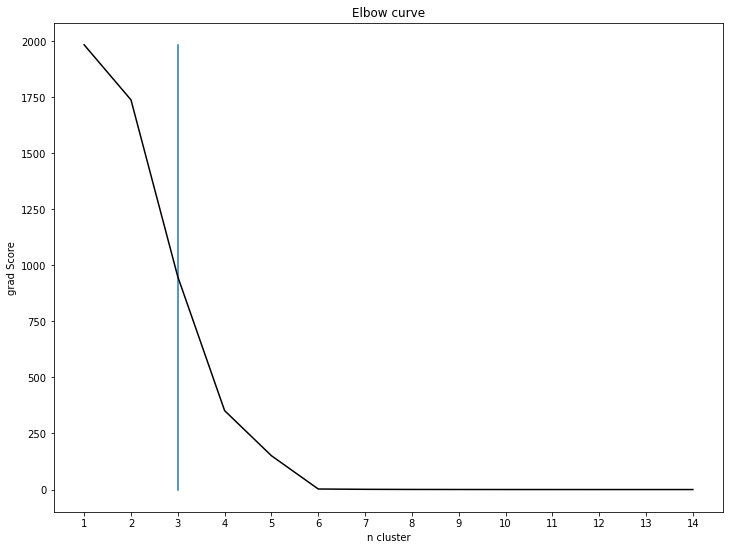

In [29]:
plt.figure(figsize=(12,9))
plt.title('Elbow curve')
plt.xlabel('n cluster')
plt.ylabel('grad Score')
plt.plot([3,3],[0,np.max(np.gradient(k_ellbow))])
plt.xticks(np.arange(1, len(k_ellbow) + 1))
plt.plot(range(1, len(k_ellbow) + 1), np.gradient(k_ellbow), 'k');

In [30]:
## Elbow curve shows significant drop when more than 2 clusters are used.
## Minimum number of cluster for analysis is therefore 3.
##Lets use K-Means Cluster prediction for 3 clusters:
cluster = KMeans(n_clusters=5)
cluster.fit(nonan_db)
cluster_predictions = cluster.predict(nonan_db)

<ipython-input-32-49a97b95a68d>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  caxes = pd.plotting.scatter_matrix(real_nucprop_df, c=cluster_predictions, ax=ax, cmap=plt.cm.get_cmap('rainbow',5),


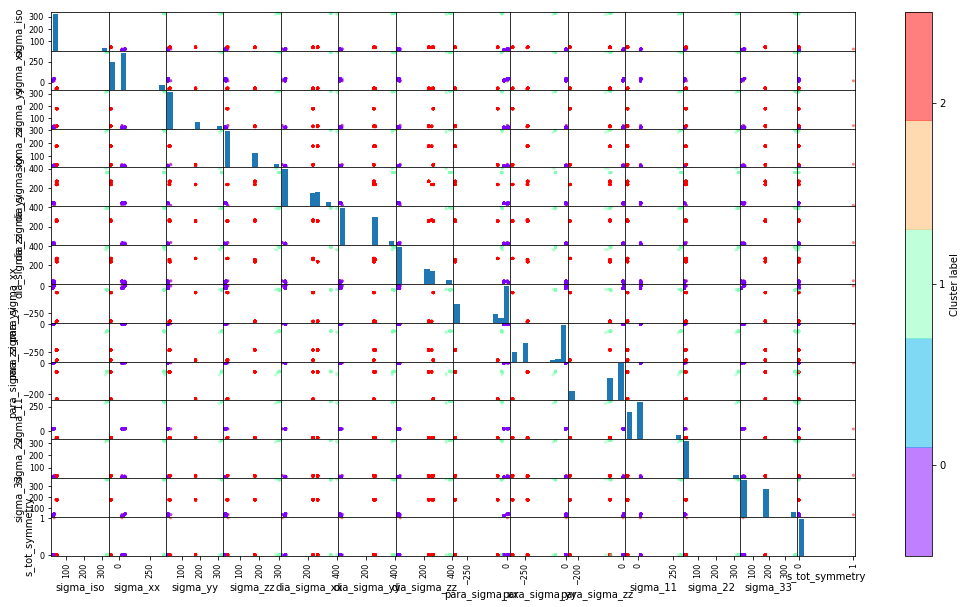

In [32]:
# We can plot the same scatter plots and color the points with the cluster labels.

fig, ax = plt.subplots(figsize=[18,10])
caxes = pd.plotting.scatter_matrix(real_nucprop_df, c=cluster_predictions, ax=ax, cmap=plt.cm.get_cmap('rainbow',3), 
    vmin=-0.5, vmax=2.5)
im = caxes[0,1].collections[0]
cbar = fig.colorbar(im, ax=caxes, ticks=range(4), label='Cluster label')

plt.show()

### Dimensionality Reduction of the Data with Principal Component Analysis.

Two ways to reduce the data dimensionality:

* PCA pojects the data in two (or more) vectors constructed as linear combinations of the original vectors. The vectors chosed are the ones that "capture the most variance", the ones that represent the most relevant directions in the data (in a linear sense)

* TSNE is a family of techniques called manifold learning (https://scikit-learn.org/stable/modules/manifold.html) . It constructs a graph by connecting each point with its neighbours, which is then disentangueled and projected in a lower dimensional space.


In [33]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(nonan_db)

In [34]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(nonan_db)

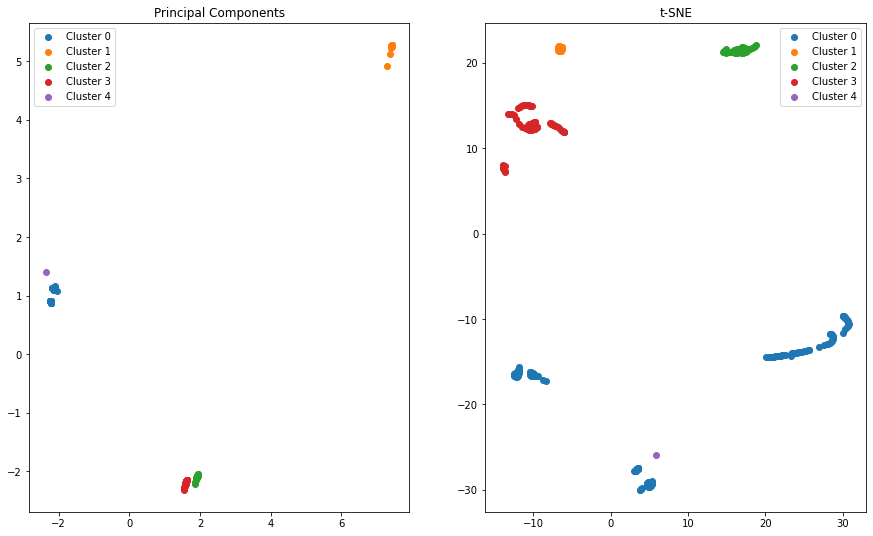

In [35]:
# Compare their 2D projections
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')
for cluster in np.unique(cluster_predictions):
    plot1 = axs[0].scatter(pca_data[cluster_predictions == cluster,0], pca_data[cluster_predictions == cluster,1], label='Cluster {}'.format(cluster))
    plot2 = axs[1].scatter(tsne_data[cluster_predictions == cluster,0], tsne_data[cluster_predictions == cluster,1], label='Cluster {}'.format(cluster))
axs[0].legend()
axs[1].legend()
#fig.colorbar(plot2, ax=axs);

## Preprocessing with @StructureModifier

Take a relaxed xyz structure with two interacting fragments and displace them relative to each other along the vector connecting the two centroids:

$$ 
p_{new} = p_{old} + \hat{d} \cdot s \cdot i
$$

where $p$ are the new and old coordinates respectively, $\hat{d}$ is the normalized displacement direction vector, $s$ is the step size and $i$ is the number of iterations you want.

In [ ]:
# Users specify relative paths
start_structure = os.path.join(scratch_dir, 'StructureModifier/input_structures/benzene_H2O_relaxH.xyz')
molecule_name = os.path.splitext(os.path.basename(start_structure))[0]

centroid_out = os.path.join(scratch_dir, f'StructureModifier/centroid_output/{molecule_name}_centroid_file.xyz')
input_file = os.path.join(scratch_dir, 'StructureModifier/input_file/input_file.txt')

In [ ]:
# Print an example of input file
with open(input_file, 'r') as file:
    input_content = file.read()
    print(input_content)

In [ ]:
# Read xyz file: this should be either a fully optimized geometry or one with relaxed H or a CREST conformer
coordinates, atom_identities = StructureModifier().read_atomic_coord(start_structure)
#print(f'Starting coordinates: {coordinates}')
#print(f'Atom identities: {atom_identities}')

In [ ]:
# Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics sof
coords1, coords2 = StructureModifier().assign_molecule_fragments(coordinates, input_file)

# Concatenate coordinates for k-means clustering
all_coords = np.concatenate((coords1, coords2), axis=0)
# print(f'All coords: {all_coords}')

# Count how many fragments you have defined in the input file, important for accurate K-means clustering
n_fragments = StructureModifier().count_fragments(input_file)
print(f"Number of '$fragment': {n_fragments}")

In [ ]:
# Perform k-means clustering to compute centroids
kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
kmeans.fit(all_coords)
centroids = kmeans.cluster_centers_

# Compute centroids for each fragment
fragment_centroids = StructureModifier().calculate_centroids([coords1, coords2])

# Write centroid coordinates to file
StructureModifier().write_centroids(centroid_out, fragment_centroids)
#print(f'Centroid coordinates: {fragment_centroids}')

In [ ]:
# Calculate displacement direction (line connecting centroids)
displacement_direction = fragment_centroids[0,:] - fragment_centroids[1,:]
displacement_direction /= np.linalg.norm(displacement_direction)
print(f'Displacement direction:{displacement_direction}')

In [ ]:
# Read displacement step size from input file
displacement_step = None
with open(input_file, 'r') as f:
    lines = f.readlines()
    read_displacement = False
    for line in lines:
        if read_displacement:
            displacement_values = line.strip().split()
            if displacement_values:
                displacement_step = float(displacement_values[0])
                break
        elif line.strip() == "$displacement":
            read_displacement = True

if displacement_step is None:
    print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
print(f'Displacement step is: {displacement_step} Angstroem') # please doublecheck that it is the same value you defined in the input

In [ ]:
# Displace the first fragment iteratively and save each structure
displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
#print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

# Initialize the coordinates for the fixed fragment (e.g., coords2)
coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
#print(f'Original coordinates fixed fragment:', coords_fixed)

all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

# Combine displaced coordinates with original ones
all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

In [ ]:
# Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
diss_lim = 20 # ANY IDEA HOW TO CALCULATE?

for i in range(0, diss_lim):  # Iterate 50 times (adjust the number as needed) 

    displacement_vector = [] 

    # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
    displaced_fragment_coords = StructureModifier().displace_fragment(coords1, displacement_direction, displacement_step, i)
    #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

    combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
    all_combined_coords.append(combined_coords)

    # Update centroids for the displaced structure
    fragment_centroid = StructureModifier().calculate_centroids([displaced_fragment_coords])
    fragment_centroids.append(fragment_centroid[0])
    #print(f'Updated centroids:', fragment_centroid)
    
    # Write displaced structure to file
    output_file = os.path.join(scratch_dir, f'StructureModifier/displaced_structures/{molecule_name}_disp_struct_{i}.xyz')
    StructureModifier().write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

    all_displaced_fragment_coords.append(displaced_fragment_coords)

    # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
    centroid_to_displaced_distance = StructureModifier().compute_distance_from_centroid(displaced_fragment_coords, centroids)
    #print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

    # Write distances to file - needed for DFT calculations outputs
    distance_output_file = os.path.join(scratch_dir, f'StructureModifier/distance_files/{molecule_name}_distances_{i}.xyz')

    StructureModifier().write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)

In [ ]:
# Plot initial topology for molecular fragments and centroids
fig = StructureModifier().plot_starting_molecular_fragments(coords1, coords2, centroids)

# Generate colors for the plots based on displacement iteration
num_iterations = len(all_displaced_fragment_coords)
colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

# Plot displaced molecular fragments and centroids
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original fragments and centroids
ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
#ax.scatter(centroids[0, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

# Plot displaced fragments and centroids
for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
    color = colors[i]
    label = f'Iteration {i}'
    ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color)
    #ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color)

    #ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
    #ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

ax.legend()
plt.show()

In [ ]:
# --- Extract the spin-spin coupling tensor components for each pair of nuclei at each distance iteration --- #

# Initialize variables for tensor components
r_AB = []
ssDSO = []
ssPSO = []
ssFC = []
ssSD = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1):
    
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output/benzene_H2O_relaxH', f'splitted_orca_job{job_number}.out'))
    
    r_ab, ssdso, sspso, ssfc, sssd = OrcaAnalysis().extract_spin_spin_couplings(orca_splitted_output)
    
    r_AB.append(r_ab)
    ssDSO.append(ssdso)
    ssPSO.append(sspso)
    ssFC.append(ssfc)
    ssSD.append(sssd)

In [ ]:
# --- Application example 2) J Coupling Tensor --- #

# Initialize an empty list to collect data
datapw = []


# Loop through the number of jobs and process each molecule
for job_number in range(n_jobs):
    molecule_name = list_molecules[job_number]
    
    # Extract the distance dictionary for the current job
    distance_dic = r_AB[job_number]
    
    # Check if the distance dictionary is valid
    if isinstance(distance_dic, dict):
        # Loop through each pair and its distance
        for (atom1, atom2), distance in distance_dic.items():
            # Create a row of data for this pair
            row_datapw = {
                'Molecule': molecule_name,
                'Atom_1': atom1,
                'Atom_2': atom2,
                'r_12': distance,
                'x_coord_1' : None, 
                'y_coord_1' : None, 
                'z_coord_1' : None, 
                'x_coord_2' : None, 
                'y_coord_2' : None, 
                'z_coord_2' : None,
                'J_iso' : None,
                'J_FC_11' : None,
                'J_FC_22' : None,
                'J_FC_33' : None,
                'J_DSO_11' : None,
                'J_DSO_22' : None,
                'J_DSO_33' : None,
                'J_PSO_11' : None,
                'J_PSO_22' : None,
                'J_PSO_33' : None,
                'J_SD_11' : None,
                'J_SD_22' : None,
                'J_SD_33' : None,
                'Mayer_BO' : None
            }
            # Append the row to the list
            datapw.append(row_datapw)

    m_bo_dict = mayer_bo[job_number]
        
    if isinstance(m_bo_dict, dict):
        for atom1, pairs in m_bo_dict.items():
            for atom2, bond_order in pairs:
                # Create a row of data for Mayer BO
                row_datapw = {
                    'Mayer_BO': bond_order
                }
                # Append the row to the Mayer BO list
                datapw.append(row_mayer_bo)

# Convert the list of rows to a DataFrame
datadf = pd.DataFrame(datapw)

# Load the existing DataFrame if needed (make sure to define `nucprop_df` earlier)
# Example: nucprop_df = pd.read_csv('existing_data.csv')

# Concatenate with the existing DataFrame
pw_nucprop_df2 = pd.concat([pw_nucprop_df, datadf], ignore_index=True)

# Save the updated DataFrame to a CSV file
#w_nucprop_df.to_csv('updated_nuclear_pairs.csv', index=False)

# Display the updated DataFrame
pw_nucprop_df2

## Visualize output with @MolView

Here is a collection of functions to visualize the shielding tensors values for selected nuclei

In [ ]:
# molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'
molecule = 'C:/Users/ettor/Desktop/NONCOV/scratch/test_structs/benzene_H2O.xyz'

MolView().plot_3d_molecule(molecule)

In [ ]:
# Plot euler angles and rotated tensor
tensor_pas = np.diag([1.0, 2.0, 3.0])  # Diagonal tensor in PAS
alpha, beta, gamma = 30, 45, 60  # Euler angles in degrees
MolView.plot_3D_tensors_and_axes(tensor_pas, alpha, beta, gamma)


## Postprocess NMR tensors with @NMRFunctions

Perform all the necessary calculations to e.g. transform a shielding tensor from the molecular frame to the PAS and order eigenvalues following either Mehring or Haberlen conventions based on user choices.

In [ ]:
# Tensor to Euler angles
mode = 'AZYZ'
order = 'Ascending'
alpha, beta, gamma, tensor_pas = NMRFunctions().tensor_to_euler(shielding_tensor, eigenvals, eigenvecs, symmetry, mode, order)

In [ ]:
# Generate equivalent sets of angles
NMRFunctions().EqEulerSet(alpha,beta,gamma)

## Modules: MolecularGraph

In [ ]:
fragment1 =(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
fragment2 = (13, 14, 15)

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(mol_dir)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
#mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)


threshold = 1.6